<a href="https://colab.research.google.com/github/kombalyn/vision/blob/master/EvaluateOnBreathsetWithDeepFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from importlib.machinery import SourceFileLoader
methods = SourceFileLoader('methods', '/content/drive/My Drive/methods.py').load_module()

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import h5py

from methods import AverageSmooth
from methods import RMSE
from methods import CrossCorrelation
from methods import calcFurierTransform
from methods import MAE
from methods import wBasedPearson

TensorFlow 1.x selected.


# Definitions

In [ ]:
wd = 200
FPS = 20

In [ ]:
'''
Load in signal from file
'''
def readFromFile(path,filename,signal):
  print("Save to this file:"+path+filename)
  print("...")
  print("saved")
  with open(path+filename,"r") as ins:
    lines = ins.readlines()
    for line in lines:
      signal.append(float(line))
  return np.asarray(signal)

In [ ]:
'''
save signal to file
'''
def saveToFile(path,filename,signal):
  print("Save to this file:"+path+filename)
  print("...")
  print("saved")
  with open(path+filename,"w") as o:
    for i in range(len(signal)):
      o.write(str(signal[i]))
      o.write("\n")

In [ ]:
def loadSignalSet(path,set):
  ujset = []
  with open(path,'r') as ins:
    lines = ins.readlines()
    for line in lines:
      values = line.split(',')
      values = values[:-1] # At the end we have an extra ','
      row = []
      for val in values:
        row.append(float(val))
      ujset.append(row)
  return np.asarray(ujset)

In [ ]:
def makeTresholdCurve(sig,division):
    tresholds = []
    for i in range(0,len(sig),division):
        window = sig[i:(i+division)]
        act_avg = np.average(window)
        for j in range(division):
            tresholds.append(act_avg)
    return tresholds

def tresholdByCurve(sig,tresholds,division,avg):
    newsig = []
    for i in range(0,len(sig),20):
        window = sig[i:(i+20)]
        trh = tresholds[i+10]
        window[window<trh] = avg
        newsig.append(np.asarray(window))
    newsig = np.asarray(newsig)
    newsig = newsig.flatten()
    sig = newsig
    return sig

def calcTreshold2(window,avg):
    upper = []
    for i in range(1,len(window)):
        if window[i-1]<=avg:
            if avg<window[i]:
                upper.append(i)
    return upper

def calcRate(sig):
    tresholds = makeTresholdCurve(sig,20)
    
    # Calculate avg:
    avg = np.average(sig)
    
    # treshold by the treshold curve:
    sig = tresholdByCurve(sig,tresholds,20,avg)
    
    # Binarization
    sig[avg<sig] = 1  
    sig[sig<avg] = avg
    
    # relative treshold set by avg:
    upper = calcTreshold2(sig,avg)

    return (len(upper)/(wd/FPS))*60

# Load Data

In [ ]:
# '''
# Load the calculated signal
# '''
# signal=[]
# signal = loadSignalSet("output/MixedDataset3",signal)
# print(signal.shape)

In [ ]:
# '''
# Load the calculated signal
# '''
# reference = []
# reference = readFromFile("output/","MixedDataset_ref3",reference)
# print(reference.shape)

In [ ]:
'''
Load the calculated signal
'''
optflowsig = []
with  open("test-breathsetWithUNET.dat","r") as ins:
  lines = ins.readlines()
  for line in lines:
    optflowsig.append(float(line))
#optflowsig = np.asarray(optflowsig)
optflowsig = np.asarray(optflowsig)

In [ ]:
'''
Load the calculated signal
'''
refflow = []
with  open("test-breathsetWithUNET_ref.dat","r") as ins:
  lines = ins.readlines()
  for line in lines:
    refflow.append(float(line[1:3]))
refflow = np.asarray(refflow)

90943


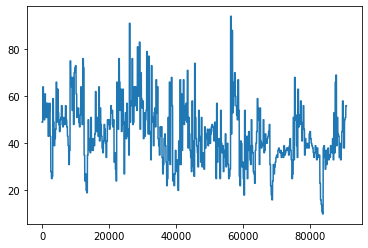

In [ ]:
print(len(refflow))
plt.plot(refflow)

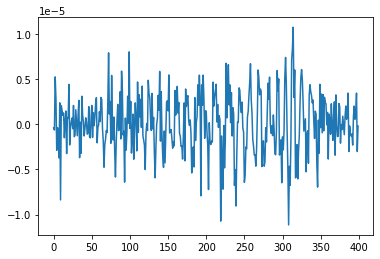

In [ ]:
plt.plot(optflowsig[41000:41400])

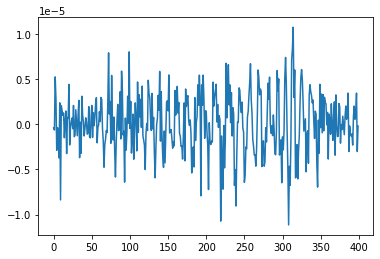

In [ ]:
plt.plot(optflowsig[41000:41400])

In [ ]:
#sig = optflowsig[20000:20400]
sig = optflowsig[41000:41400]

In [ ]:
maxes=findLocalMaximas(sig,8)

In [ ]:
print(maxes)

[  8  27  42  64  84  99 112 123 137 151 163 172 186 202 222 240 256 269
 282 295 314 325 338 350 365 382 395]


In [ ]:
envelop = getEnvelope(sig,maxes)
print(len(envelop))

[  0.   8.  27.  42.  64.  84.  99. 112. 123. 137. 151. 163. 172. 186.
 202. 222. 240. 256. 269. 282. 295. 314. 325. 338. 350. 365. 382. 395.]
400


In [ ]:
def findLocalMaximas(sig,horizontal_treshold):
  places = []
  places.append(0)
  for i in range(1,len(sig)-1):
    if(sig[i-1]<sig[i] and sig[i+1]<sig[i]):
      if (horizontal_treshold<abs(i-places[-1])):
        places.append(i)
      else:
        if (sig[places[-1]]<sig[i]):
          places[-1]=i
  #places = places[1:]
  return np.asarray(places)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


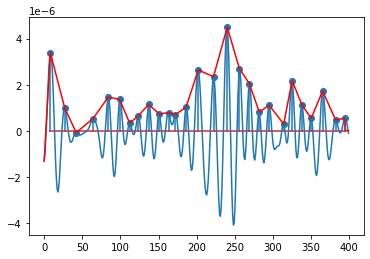

In [ ]:
plt.stem(maxes,sig[maxes])
plt.plot(sig)
plt.plot(envelop,'r')

In [ ]:
def getEnvelope(sig,locMaximas):
  envelop = []
  locMaximas = np.concatenate((np.zeros(1),locMaximas))
  print(locMaximas)
  for i in range(1,len(locMaximas)):
    x_dif = abs(locMaximas[i]-locMaximas[i-1])
    y_dif = sig[int(locMaximas[i])]-sig[int(locMaximas[i-1])]
    m = y_dif/x_dif
    act_y = sig[int(locMaximas[i-1])]
    for j in range(int(locMaximas[i-1]),int(locMaximas[i])):
      act_y = sig[int(locMaximas[i-1])] + m*(j-int(locMaximas[i-1]))#ig[int(locMaximas[i-1])]#m*j
      envelop.append(act_y)
  x_dif = abs(len(sig)-locMaximas[-1])
  y_dif = abs(sig[int(len(sig)-1)]-sig[int(locMaximas[-1])])
  m = y_dif/x_dif
  act_y = sig[int(locMaximas[-1])]
  for j in range(int(locMaximas[-1]),len(sig)):
    act_y = 0#m*j
    envelop.append(act_y)
  return envelop

# Band Pass Filtering

In [ ]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 30.0
lowcut = 1/6
highcut = 2

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
optflowsig = butter_bandpass_filter(optflowsig, lowcut, highcut, fs, order=6)

# Reshape signals to [wd,wd]

In [ ]:
signal = []
for i in range(0,len(optflowsig),200):
  seq = optflowsig[i:(i+200)]
  if (len(seq)==200):
    signal.append(seq)
signal = np.asarray(signal)
print(signal.shape)

(454, 200)


In [ ]:
reference = []
for i in range(0,len(refflow),200):
  seq = refflow[i:(i+200)]
  if (len(seq)==200):
    reference.append(seq[100])
reference = np.asarray(reference)
print(reference.shape)

(454,)


# Demo

In [ ]:
def mynorm(sig):
  avg = np.mean(sig)
  sig = sig - np.ones_like(sig)*avg
  sig = sig / np.max(sig)
  return sig

In [ ]:
import time

In [ ]:
output_rates = []
#refs = []
for i in range(0,len(signal)):
  sig = np.asarray(mynorm(signal[i]))
  sig = np.reshape(sig, [1,wd])
  t0= time.clock()
  r =  calcRate(sig)
  t1 = time.clock()
  print("Time elapsed: ", t1 - t0) # CPU seconds elapsed (floating point)
  output_rates.append(r)

  #refs.append(np.mean(reference_train[i:i+wd]))

Time elapsed:  0.00026499999999973767
Time elapsed:  0.00017900000000015126
Time elapsed:  0.00017900000000015126
Time elapsed:  0.00019199999999974793
Time elapsed:  0.00018699999999993722
Time elapsed:  0.00016499999999997073
Time elapsed:  0.0002089999999999037
Time elapsed:  0.00020800000000020802
Time elapsed:  0.0001719999999996169
Time elapsed:  0.00018399999999996197
Time elapsed:  0.00023700000000026478
Time elapsed:  0.00017099999999992122
Time elapsed:  0.00021599999999999397
Time elapsed:  0.0003069999999998352
Time elapsed:  0.00020799999999976393
Time elapsed:  0.00020199999999981344
Time elapsed:  0.00030300000000016425
Time elapsed:  0.000264000000000042
Time elapsed:  0.00025999999999992696
Time elapsed:  0.00023899999999965615
Time elapsed:  0.00011399999999994748
Time elapsed:  0.00021100000000018326
Time elapsed:  0.000256000000000256
Time elapsed:  0.00019900000000028228
Time elapsed:  0.00026999999999999247
Time elapsed:  0.00020700000000006824
Time elapsed:  0.00

In [ ]:
# absolute error
errors = []
for i in range(len(output_rates)):
  errors.append(abs(output_rates[i]-reference[i]))
print(np.mean(errors))

11.883259911894273


In [ ]:
output_rates = np.asarray(output_rates)
print(output_rates.shape)
print(reference[:300].shape)

(454,)
(300,)


In [ ]:
output_rates = output_rates.flatten()

In [ ]:
output_rates = np.reshape(output_rates, [len(output_rates)])

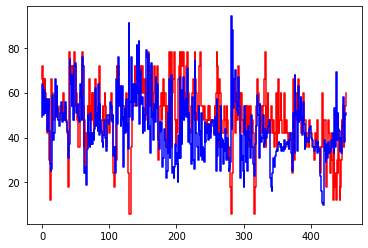

In [ ]:
plt.step(output_rates,'r')
plt.step(reference,'b')

#Numerical Evaluation

In [ ]:
import math

In [ ]:
# Normalize signal
def mynormalize(sig):
  avg = np.mean(sig)
  sig = sig - np.ones_like(sig)*avg
  sig = sig / np.max(sig)
  return sig

def myNorm(sig,ref):
    breathset2 = sig
    breathset1 = ref
    breathset1 = breathset1 - np.mean(breathset1)
    breathset2 = breathset2 - np.mean(breathset2)
    if (breathset1.size == 0):
        return None, None
    else:
        if (math.isnan(np.max(breathset1))):
            return None, None
        else:
            breathset1 = breathset1 / np.max(breathset1)
            breathset2 = breathset2 / np.max(breathset2)
            return breathset2, breathset1

RMSEs = []
MAEs = []
Coeffs =[]
for i in range(0,len(output_rates)-200,200):
    #sig_normed, ref_normed = myNorm(output_rates[i:(i+200)],reference[i:(i+200)])
    if (True):
        RMSEs.append(RMSE(output_rates[i:(i+200)],reference[i:(i+200)]))
        Coeffs.append(wBasedPearson(output_rates[i:(i+200)],reference[i:(i+200)]))
        MAEs.append(MAE(output_rates[i:(i+200)],reference[i:(i+200)]))

In [ ]:
print(np.mean(RMSEs))
print(np.mean(Coeffs))
print(np.mean(MAEs))

16.866912683537684
0.16245805058148022
11.9525


# Save evaluation

In [ ]:
saveToFile("output/","CalcRate-on-Breathset-2020-04-28",output_rates)
saveToFile("output/","CalcRate-on-Breathset-2020-04-28-ref",reference)

Save to this file:output/CalcRate-on-Breathset-2020-04-28
...
saved
Save to this file:output/CalcRate-on-Breathset-2020-04-28-ref
...
saved
